In [1]:
'''
To compute CD signatures for LINCS L1000 level3 data using 
all profiles in the same batch as controls
and add results to mongodb.
''' 
import os, sys, json
import h5py
from pymongo import MongoClient
import geode

sys.path.append('/Users/zichen/Documents/bitbucket/maayanlab_utils')
from parallel import *
from fileIO import file2list
import RNAseq

sys.path.append('/Users/zichen/Documents/GitHub/l1ktools/python')
import cmap.io.gct as gct


/usr/local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 ## Output Type 3 (Type3) or Type 42 (TrueType)
rcParams['font.sans-serif'] = 'Arial'

import seaborn as sns
sns.set_context('talk', font_scale=1.5)


/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# 0. Load LINCS L1000 level 3 data from gctx file and made function to subset this matrix by probe_ids and sample_ids

In [3]:
GCTX_FILE = '/Users/zichen/Documents/Zichen_Projects/L1000_DR/data/q2norm_n1328098x22268.gctx'
PROBES = json.load(open('/Users/zichen/Documents/bitbucket/lincs_l1000_limma/rid.json', 'rb'))
PROBES_LM1000 = file2list('/Users/zichen/Documents/bitbucket/lincs_l1000_limma/rid_lm1000.txt', 0)

print len(PROBES), len(PROBES_LM1000)
print PROBES[:5]
print PROBES_LM1000[:5]

22268 978
[u'200814_at', u'222103_at', u'201453_x_at', u'204131_s_at', u'200059_s_at']
['200814_at', '222103_at', '201453_x_at', '204131_s_at', '200059_s_at']


In [4]:
gctx = h5py.File(GCTX_FILE, 'r')
mat = gctx['/0/DATA/0/matrix']
print mat.shape

gene_ids = list(gctx['/0/META/ROW/id'])
print len(gene_ids), gene_ids[:5]

(1328098, 22268)
22268 ['200814_at', '222103_at', '201453_x_at', '204131_s_at', '200059_s_at']


In [5]:
gctx['/0/META/COL/id'][:5]

array(['CPC005_A375_6H_X1_B3_DUO52HI53LO:K06',
       'CPC005_A375_6H_X2_B3_DUO52HI53LO:K06',
       'CPC005_A375_6H_X3_B3_DUO52HI53LO:K06',
       'CPC005_A375_6H_X1_B3_DUO52HI53LO:C19',
       'CPC005_A375_6H_X2_B3_DUO52HI53LO:C19'], 
      dtype='|S46')

In [6]:
def slice_matrix(gctx, cids, rids):
    '''Slice the mat by cids and rids and ensure the mat 
    is ordered by cids and rids.'''    
    all_cids = gctx['/0/META/COL/id']
    c_mask = np.in1d(all_cids, cids)
    cids_subset = all_cids[c_mask].tolist()
    c_indices = np.array([cids_subset.index(id_) 
                          for id_ in cids])

    mat = gctx['/0/DATA/0/matrix']
    submat = mat[c_mask, :][c_indices, :]
    
    all_rids = gctx['/0/META/ROW/id']
    r_mask = np.in1d(all_rids, rids)
    rids_subset = all_rids[r_mask].tolist()
    r_indices = np.array([rids_subset.index(id_) 
                          for id_ in rids])
    submat = submat[:, r_mask][:, r_indices]

    return submat

# 1. Connect to MongoDB to retrieve all `sig_id`s that are `trt_cp`

In [7]:
client = MongoClient("mongodb://146.203.54.131:27017")
DB = client['LINCS_L1000_limma']

In [8]:
# Get all the distil_id for control samples
COLL_INST = DB['instinfo']
cur = COLL_INST.find({'pert_type': {'$in': ['ctl_vehicle', 'trt_cp']}}, 
                     {'_id':False, 
                      'distil_id':True, 
                      'pert_id':True,
                      'pert_type':True
                     })

distil_df = pd.DataFrame([doc for doc in cur]).set_index('distil_id')
print distil_df.shape
distil_df.head()

(692151, 2)


,pert_id,pert_type
distil_id,,
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:F13,DMSO,ctl_vehicle
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:G13,DMSO,ctl_vehicle
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:I13,DMSO,ctl_vehicle
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:K13,DMSO,ctl_vehicle
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:N13,DMSO,ctl_vehicle


In [18]:
# COLL_INST.distinct('pert_type')

[u'ctl_vehicle',
 u'trt_cp',
 u'trt_poscon',
 u'trt_lig',
 u'ctl_vector',
 u'trt_sh',
 u'ctl_untrt',
 u'trt_oe',
 u'trt_oe.mut']

In [9]:
def distil_id_to_rna_plate(did):
    return '_'.join(did.split('_')[:4])

def distil_id_to_batch(did):
    return '_'.join(did.split('_')[:3])

distil_df['rna_plate'] = distil_df.index.map(distil_id_to_rna_plate)
distil_df['batch'] = distil_df.index.map(distil_id_to_batch)
distil_df['rna_plate'].value_counts()

CPC014_A375_6H_X1         745
CPC008_A375_6H_X1         743
CPC006_HT29_6H_X1         740
CPC012_A375_6H_X1         740
CPC006_MCF7_24H_X3        731
CPC010_A375_6H_X2         730
CPC006_HCC515_6H_X2       730
CPC015_MCF7_6H_X3         730
CPC009_PC3_6H_X3          728
CPC006_A375_6H_X1         728
CPC014_MCF7_6H_X2         725
CPC006_HCC515_24H_X4      723
CPC006_PC3_24H_X2         723
CPC006_SW948_6H_X2        722
CPC013_HT29_6H_X1         721
CPC019_PC3_24H_X1         720
CPC005_MCF7_6H_X2         715
CPC001_PC3_24H_X3         713
CPC006_HEC108_6H_X1       709
CPC006_A375_6H_X2         709
PCLB001_HT29_24H_X3       707
CPC007_VCAP_24H_X1        703
CPC006_SW620_6H_X2        698
PCLB001_JURKAT_6H_X1      691
CPC006_SW948_6H_X1        684
CPC006_SW620_6H_X1        681
CPC006_RMUGS_6H_X2        675
CPC006_HA1E_24H_X1.A2     674
DOS032_A549_24H_X1        667
CPC006_THP1_6H_X1         652
                         ... 
LJP004_MDAMB231_6H_X2       3
LJP004_MDAMB231_24H_X2      3
LJP004_MDA

In [10]:
distil_df['batch'].value_counts()

CPC009_PC3_6H          2541
CPC006_A375_6H         2524
CPC006_HT29_6H         2210
CPC012_A375_6H         2206
CPC015_MCF7_6H         2199
CPC007_VCAP_6H         2185
CPC006_MCF7_24H        2178
CPC013_HT29_6H         2174
CPC001_VCAP_6H         2174
CPC001_PC3_24H         2172
CPC006_PC3_24H         2170
CPC014_MCF7_6H         2167
CPC006_HCC515_24H      2161
CPC019_PC3_24H         2160
CPC001_VCAP_24H        2158
CPC004_VCAP_24H        2138
CPC007_VCAP_24H        2135
PCLB001_A375_24H       2078
ERG012_VCAP_24H        1940
CPC007_MCF7_24H        1841
CPC008_PC3_6H          1839
CPC003_PC3_24H         1834
CPC008_HT29_6H         1834
CPC012_MCF7_6H         1834
CPC019_MCF7_24H        1833
CPC010_PC3_24H         1833
CPC020_A375_6H         1832
CPC012_PC3_24H         1832
CPC020_MCF7_24H        1831
CPC017_HT29_6H         1831
                       ... 
LJP004_SKBR3_24H         13
LJP003_BT20_24H          13
LJP003_HS578T_24H        12
LJP003_MCF7_24H          11
LJP003_SKBR3_6H     

In [11]:
def distil_id_to_det_plate(did):
    return '_'.join(did.split('_')[:5])

distil_df['det_plate'] = distil_df.index.map(distil_id_to_det_plate)

In [12]:
# One well could have been profiled multiple times by different bead_batch?
distil_df.query('rna_plate == "CPC014_A375_6H_X1" & pert_id == "BRD-A06929388"')

,pert_id,pert_type,rna_plate,batch,det_plate
distil_id,,,,,
CPC014_A375_6H_X1_F1B3_DUO52HI53LO:B11,BRD-A06929388,trt_cp,CPC014_A375_6H_X1,CPC014_A375_6H,CPC014_A375_6H_X1_F1B3
CPC014_A375_6H_X1_B4_DUO52HI53LO:B11,BRD-A06929388,trt_cp,CPC014_A375_6H_X1,CPC014_A375_6H,CPC014_A375_6H_X1_B4


In [13]:
distil_df['det_plate'].value_counts()

CPC005_HCC515_6H_X2_F1B4            375
CPC006_SKMEL1_6H_X2_B4              375
CPC007_MCF7_24H_X3_B5               374
CPC010_MCF7_24H_X1_B5               374
CPC008_HEPG2_6H_X2_B4               374
CPC019_A375_6H_X3_B4                373
CPC008_A375_6H_X1_F1B3              373
CPC014_A375_6H_X1_F1B3              373
CPC013_HT29_6H_X1_F1B3              373
CPC008_A375_6H_X2_B3                373
CPC010_HA1E_6H_X2_B4                373
CPC009_PC3_24H_X1_F1B4              373
CPC006_HT29_6H_X1_B3                373
CPC007_A549_6H_X3_B3                372
CPC007_HCC515_6H_X2_F1B3            372
CPC005_HT29_24H_X1_B3               372
CPC014_A375_6H_X1_B4                372
CPC005_A375_24H_X1_B3               372
CPC005_A375_6H_X3_B3                372
CPC012_MCF7_6H_X2_B4                372
CPC007_A549_6H_X2_B3                372
CPC020_PC3_6H_X3_B4                 372
CPC009_HCC515_6H_X3_B4              372
CPC014_MCF7_6H_X1_B4                372
CPC006_PC3_6H_X4_B4                 372


In [14]:
from scipy.stats.mstats import zscore
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

def PCA_plot(mat, samples, standardize=3):
    if standardize == 2: # standardize along rows/genes
        mat = zscore(mat, axis=1)
    elif standardize == 1: # standardize along cols/samples
        mat = zscore(mat, axis=0)
    
    pca = PCA(n_components=3)
    ## get variance captured
    pca.fit(mat.T)
    variance_explained = pca.explained_variance_ratio_[0:3]
    variance_explained *= 100
    ## compute PCA and plot
    pca_transformed = pca.transform(mat.T)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    scatter_proxies = []
    labels_show = []
    groups = {}
    conditions = list(set(samples))

    colors = RNAseq.COLORS10
    if len(conditions) > 10:
        colors = RNAseq.COLORS20

    for row, label in zip(pca_transformed, samples):
        label_show = label
        idx = conditions.index(label_show)
        ax.scatter(row[0], row[1], label='label', color=colors[idx], 
                   s=10, marker='o',
                   alpha=0.7
                  )
        if label_show not in labels_show:
            labels_show.append(label_show)
            scatter1_proxy = Line2D([0],[0], ls="none", c=colors[idx], marker='o')
            scatter_proxies.append(scatter1_proxy)

    ax.legend(scatter_proxies, labels_show, numpoints=1, frameon=True,
              loc='best', prop={'size':14})
    ax.set_xlabel('PC1 (%.2f'%variance_explained[0] + '%' + ' variance captured)', fontsize=20)
    ax.set_ylabel('PC2 (%.2f'%variance_explained[1] + '%' + ' variance captured)', fontsize=20)
    fig.tight_layout()
    return fig

In [26]:
def mean_center(mat, centerby):
    '''Mean center a mat based on centerby. mat is a samples x genes matrix'''
    mat_centered = np.zeros_like(mat)
    
    for group in set(centerby):
        mask = np.in1d(centerby, [group])
        mat_centered[mask] = mat[mask] - mat[mask].mean(axis=0)
    
    return mat_centered

## 2.1. Examine samples on a batch 


In [27]:
meta_df = distil_df.query('batch == "CPC009_PC3_6H"')
mat = slice_matrix(gctx,
                   meta_df.index.tolist(),
                   PROBES_LM1000)
print mat.shape, meta_df.shape

(2541, 978) (2541, 5)


In [17]:
meta_df['det_plate'].value_counts()

CPC009_PC3_6H_X3_F1B3     369
CPC009_PC3_6H_X2_B3       367
CPC009_PC3_6H_X1_B3       366
CPC009_PC3_6H_X5_F1B5     364
CPC009_PC3_6H_X4_F1B5     359
CPC009_PC3_6H_X3_B3       359
CPC009_PC3_6H_X3.A2_B4    357
Name: det_plate, dtype: int64

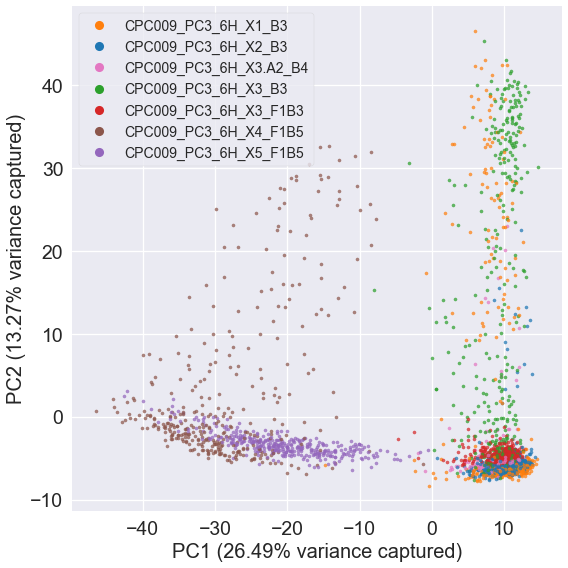

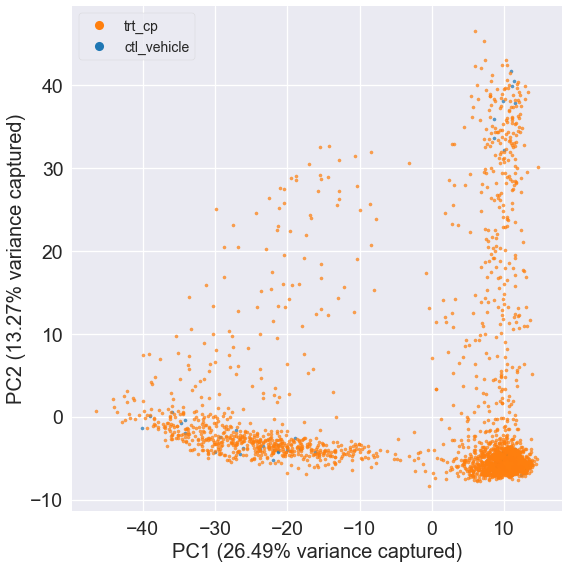

In [31]:
fig = PCA_plot(mat.T, meta_df['det_plate'], standardize=2)
fig = PCA_plot(mat.T, meta_df['pert_type'], standardize=2)

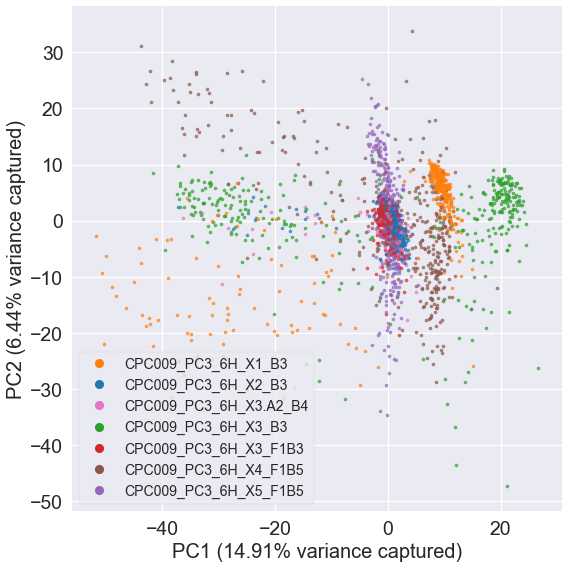

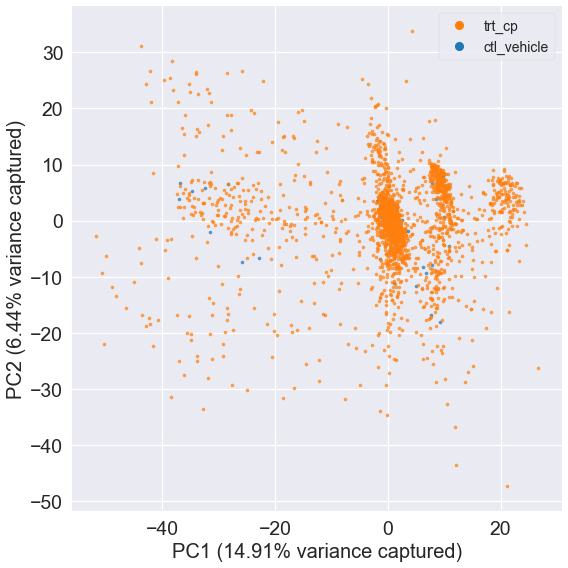

In [30]:
mat_centered_by_det = mean_center(mat, meta_df['det_plate'])
fig = PCA_plot(mat_centered_by_det.T, meta_df['det_plate'], standardize=2)
fig = PCA_plot(mat_centered_by_det.T, meta_df['pert_type'], standardize=2)

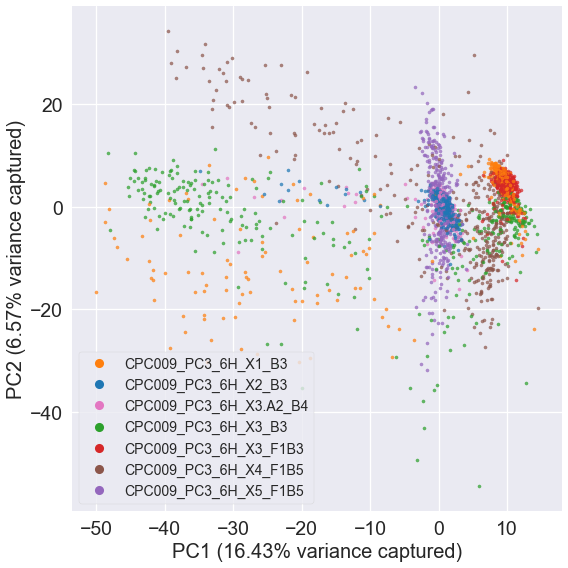

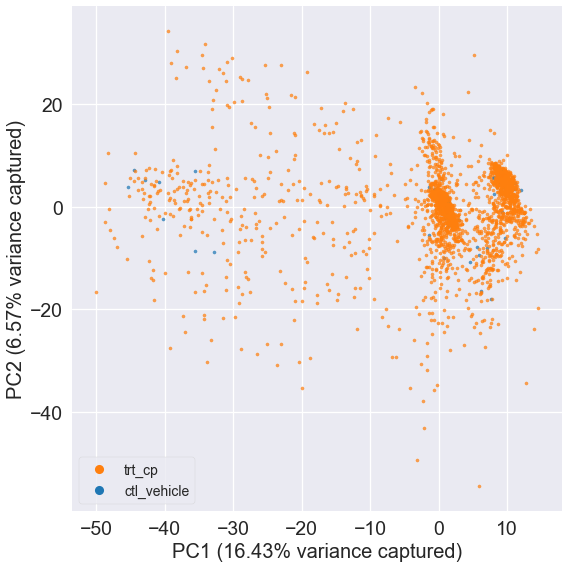

In [33]:
mat_centered_by_rna = mean_center(mat, meta_df['rna_plate'])
fig = PCA_plot(mat_centered_by_rna.T, meta_df['det_plate'], standardize=2)
fig = PCA_plot(mat_centered_by_rna.T, meta_df['pert_type'], standardize=2)

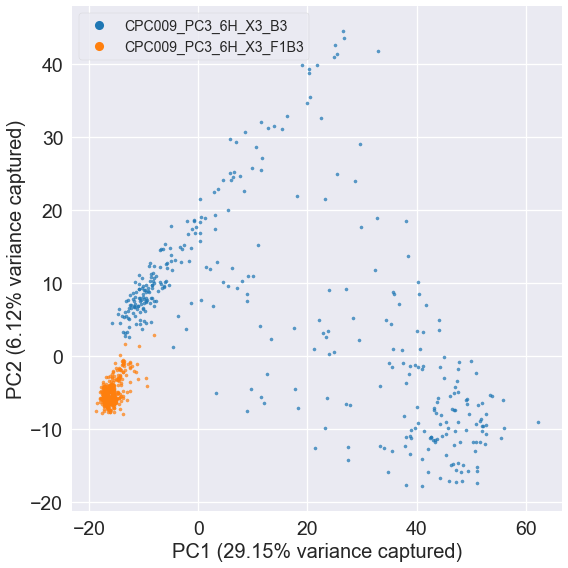

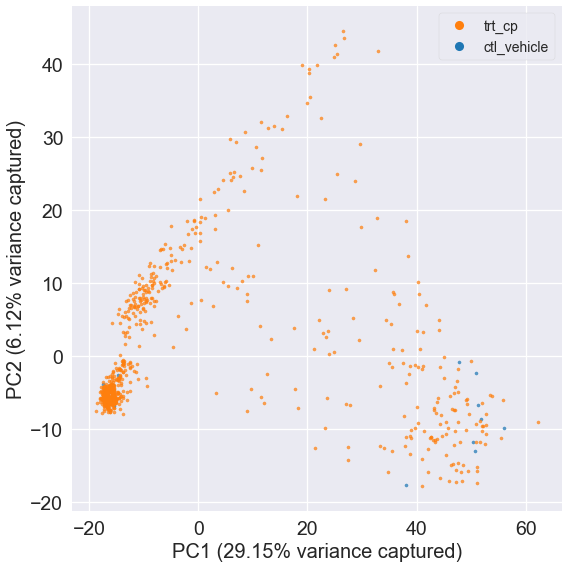

In [19]:
sample_mask = meta_df['rna_plate'] == 'CPC009_PC3_6H_X3'
fig = PCA_plot(mat[sample_mask].T, meta_df.loc[sample_mask]['det_plate'], standardize=3)
fig = PCA_plot(mat[sample_mask].T, meta_df.loc[sample_mask]['pert_type'], standardize=3)

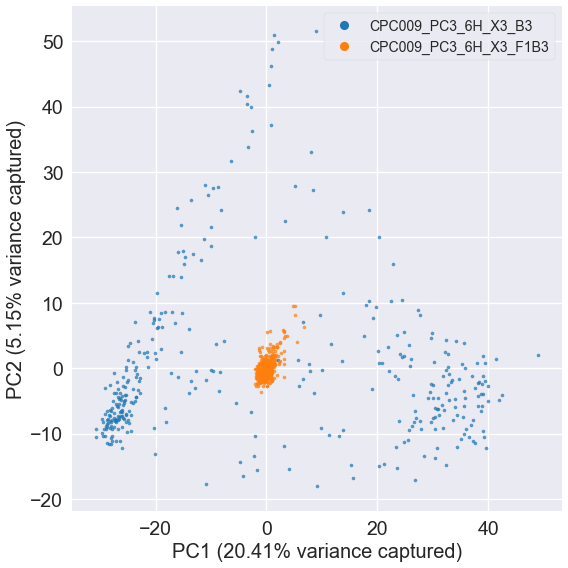

In [34]:
sample_mask = meta_df['rna_plate'] == 'CPC009_PC3_6H_X3'
fig = PCA_plot(mat_centered_by_det[sample_mask].T, meta_df.loc[sample_mask]['det_plate'], standardize=3)

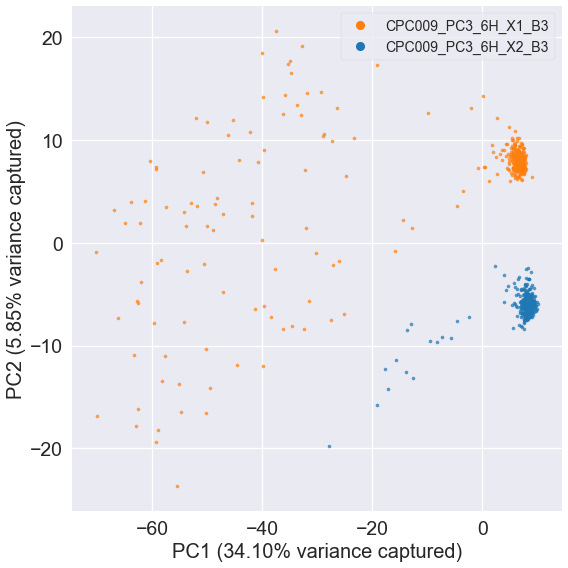

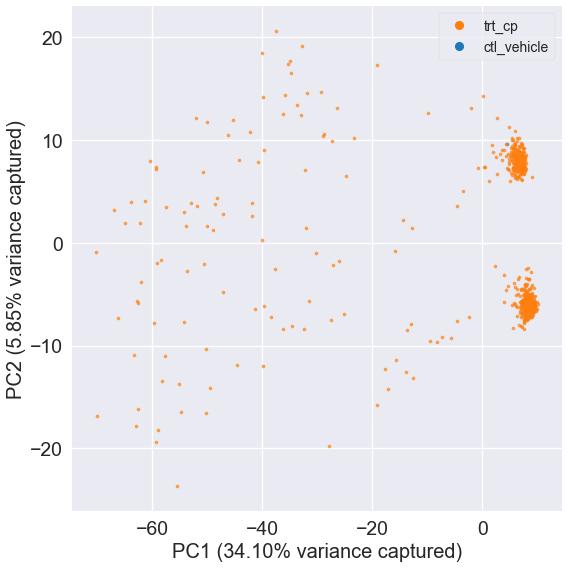

In [20]:
sample_mask = meta_df['rna_plate'].isin(['CPC009_PC3_6H_X1', 'CPC009_PC3_6H_X2'])
fig = PCA_plot(mat[sample_mask].T, meta_df.loc[sample_mask]['det_plate'], standardize=3)
fig = PCA_plot(mat[sample_mask].T, meta_df.loc[sample_mask]['pert_type'], standardize=3)

In [21]:
# Another batch
meta_df = distil_df.query('batch == "CPC006_A375_6H"')
mat = slice_matrix(gctx,
                   meta_df.index.tolist(),
                   PROBES_LM1000)
print mat.shape, meta_df.shape

(2524, 978) (2524, 5)


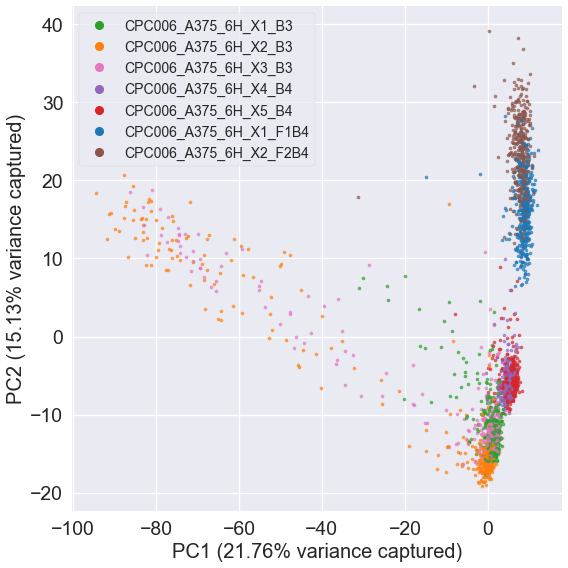

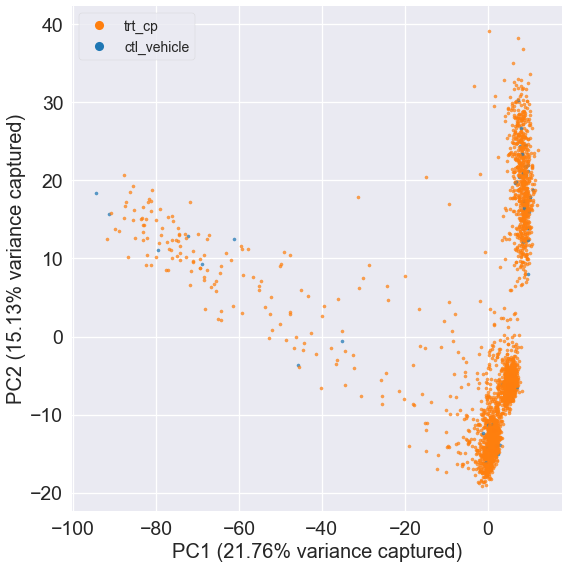

In [22]:
fig = PCA_plot(mat.T, meta_df['det_plate'], standardize=3)
fig = PCA_plot(mat.T, meta_df['pert_type'], standardize=3)

In [35]:
# Two batches with the same prefix different cell types
meta_df = distil_df.query('batch == "CPC006_A375_6H" | batch == "CPC006_HT29_6H"')
mat = slice_matrix(gctx,
                   meta_df.index.tolist(),
                   PROBES_LM1000)
print mat.shape, meta_df.shape

(4734, 978) (4734, 5)


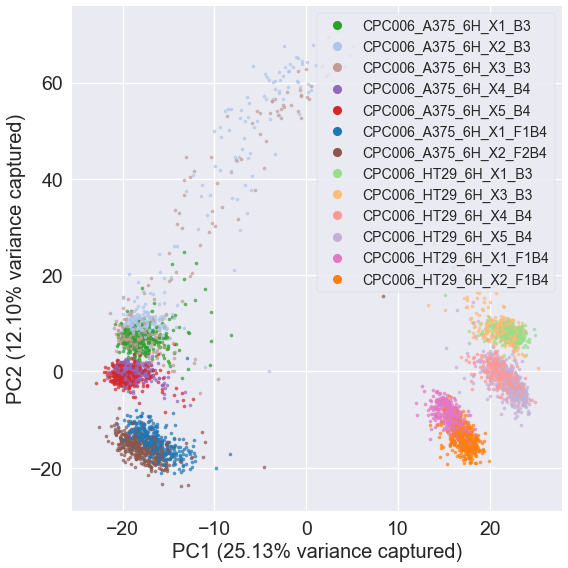

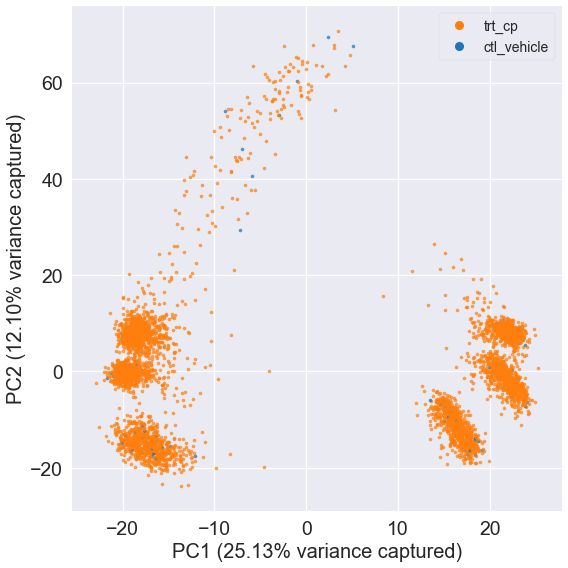

In [36]:
fig = PCA_plot(mat.T, meta_df['det_plate'], standardize=3)
fig = PCA_plot(mat.T, meta_df['pert_type'], standardize=3)

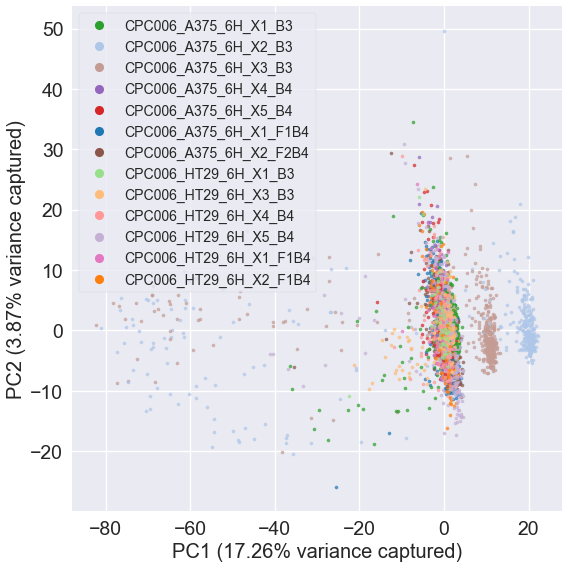

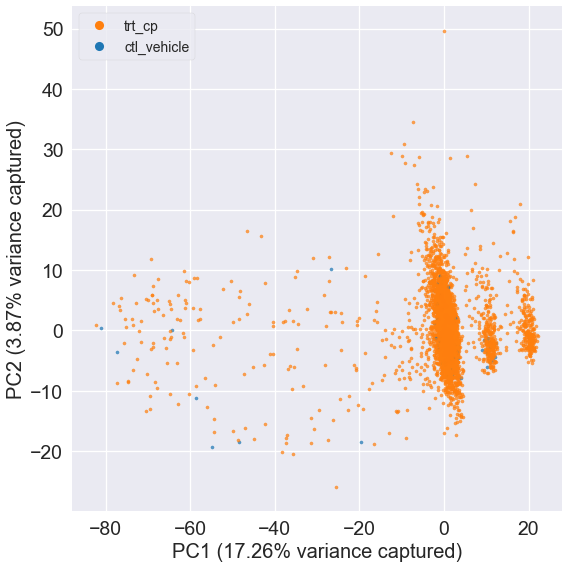

In [37]:
mat_centered_by_det = mean_center(mat, meta_df['det_plate'])
fig = PCA_plot(mat_centered_by_det.T, meta_df['det_plate'], standardize=3)
fig = PCA_plot(mat_centered_by_det.T, meta_df['pert_type'], standardize=3)

(4342, 978) (4342, 5)


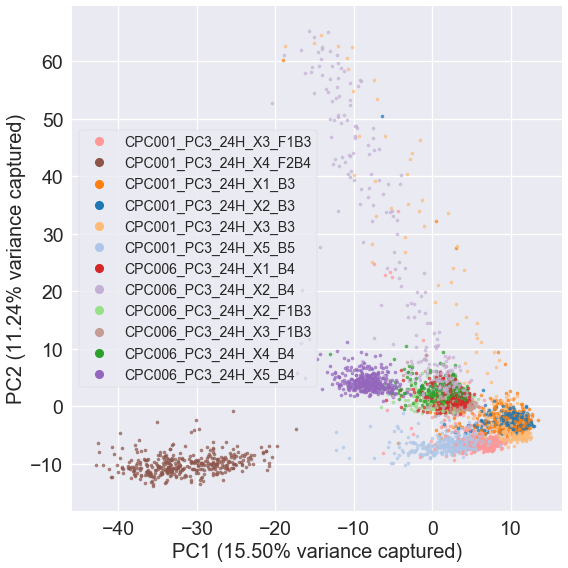

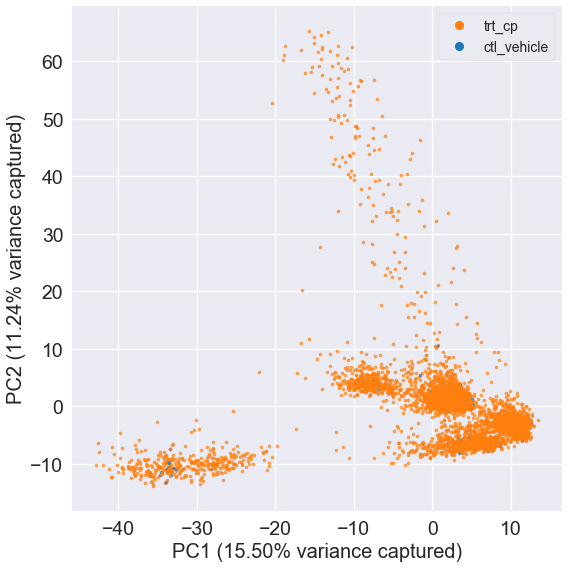

In [25]:
# Two batches with the same different prefix same cell type
meta_df = distil_df.query('batch == "CPC001_PC3_24H" | batch == "CPC006_PC3_24H"')
mat = slice_matrix(gctx,
                   meta_df.index.tolist(),
                   PROBES_LM1000)
print mat.shape, meta_df.shape

fig = PCA_plot(mat.T, meta_df['det_plate'], standardize=3)
fig = PCA_plot(mat.T, meta_df['pert_type'], standardize=3)

## 2.2. Examine the effect of mean centering for samples on batch and on plates

In [24]:
# Look at a particular signature
# sig_id = 'CPC004_A375_6H:BRD-K34820100-001-02-1:10'
sig_id = 'CPC004_MCF7_6H:BRD-K34820100-001-02-1:10'
distil_ids = sig_meta_df.ix[sig_id]['distil_id']
batch = sig_meta_df.ix[sig_id]['batch']
plates = map(distil_id_to_rna_plate, distil_ids)
print distil_ids
print batch
print set(plates)

[u'CPC004_MCF7_6H_X1_B3_DUO52HI53LO:N23', u'CPC004_MCF7_6H_X2_B3_DUO52HI53LO:N23', u'CPC004_MCF7_6H_X4_F1B5_DUO52HI53LO:N23']
CPC004_MCF7_6H
set([u'CPC004_MCF7_6H_X4', u'CPC004_MCF7_6H_X2', u'CPC004_MCF7_6H_X1'])


In [107]:
# Get all the treatment samples in this batch
distil_ids_sub = reduce(lambda x, y: x + y, 
                        sig_meta_df_full.query('batch == "%s"' % batch)['distil_id'])
distil_ids_sub = sorted(distil_ids_sub)
print len(distil_ids_sub)
plate_ids_sub = map(lambda x:x.split(':')[0], distil_ids_sub)
print len(set(plate_ids_sub))

1414
4


In [108]:
# Retrieve the expression matrix on this batch
mat_sub = slice_matrix(gctx, distil_ids_sub, PROBES_LM1000)
print mat_sub.shape

(1414, 978)


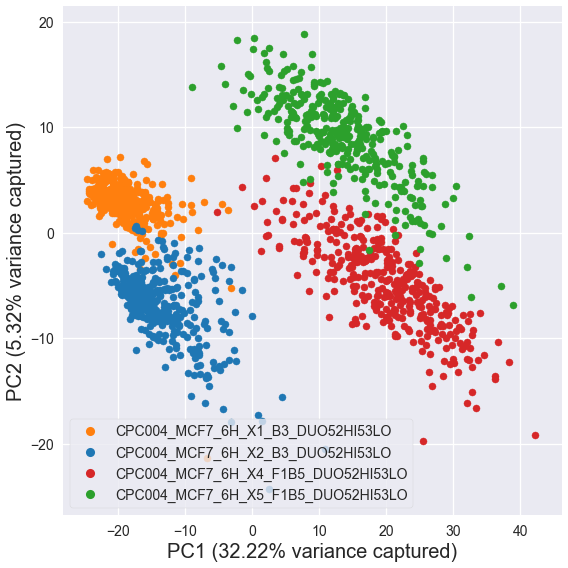

In [109]:
RNAseq.PCA_plot(mat_sub.T, samples=distil_ids_sub, standardize=2, log=False,  sep=':')

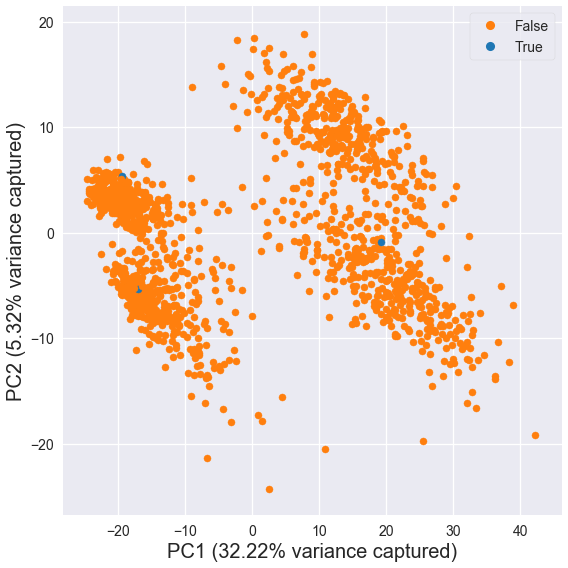

In [110]:
# Highlight the 5 treatment samples of interest
RNAseq.PCA_plot(mat_sub.T, samples=np.in1d(distil_ids_sub, distil_ids).astype(str), standardize=2, log=False,  sep=' ')

In [111]:
# Mean center the probes
mat_sub_centered = mat_sub - mat_sub.mean(axis=0)
print mat_sub_centered.shape

(1414, 978)


In [112]:
# Look at another signature of the same drug, same cell on a different batch
# sig_id2 = 'CPC015_A375_6H:BRD-K34820100-001-02-1:10'
sig_id2 = 'CPC015_MCF7_6H:BRD-K34820100-001-02-1:10'
distil_ids2 = sig_meta_df.ix[sig_id2]['distil_id']
batch2 = sig_meta_df.ix[sig_id2]['batch']
print distil_ids2
print batch2

[u'CPC015_MCF7_6H_X1_B4_DUO52HI53LO:B13', u'CPC015_MCF7_6H_X2_B4_DUO52HI53LO:B13', u'CPC015_MCF7_6H_X3_B3_DUO52HI53LO:B13', u'CPC015_MCF7_6H_X3_B4_DUO52HI53LO:B13', u'CPC015_MCF7_6H_X4_F2B4_DUO52HI53LO:B13', u'CPC015_MCF7_6H_X5_F1B5_DUO52HI53LO:B13']
CPC015_MCF7_6H


In [113]:
# Get all the treatment samples in this batch
distil_ids_sub2 = reduce(lambda x, y: x + y, 
                        sig_meta_df_full.query('batch == "%s"' % batch2)['distil_id'])
distil_ids_sub2 = sorted(distil_ids_sub2)
print len(distil_ids_sub2)
plate_ids_sub2 = map(lambda x:x.split(':')[0], distil_ids_sub2)
print len(set(plate_ids_sub2))

2171
6


In [114]:
# Retrieve the expression matrix on this batch
mat_sub2 = slice_matrix(gctx, distil_ids_sub2, PROBES_LM1000)
print mat_sub2.shape

(2171, 978)


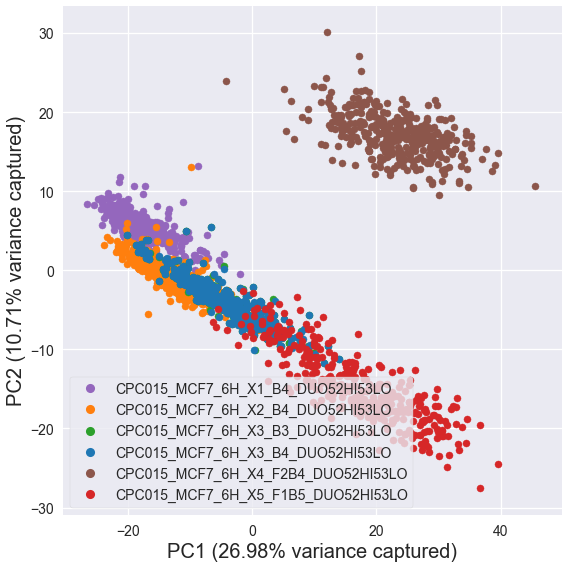

In [115]:
RNAseq.PCA_plot(mat_sub2.T, samples=distil_ids_sub2, standardize=2, log=False,  sep=':')

(3585, 978)
3585


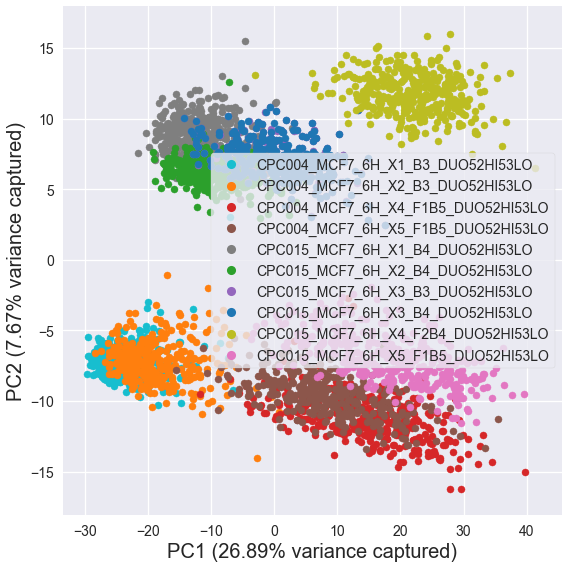

In [116]:
# Concat those two batches
mat_sub_sub2 = np.vstack((mat_sub, mat_sub2))
print mat_sub_sub2.shape
print len(distil_ids_sub + distil_ids_sub2)
RNAseq.PCA_plot(mat_sub_sub2.T, 
                samples=distil_ids_sub + distil_ids_sub2, 
                standardize=2, log=False,  sep=':')

3585


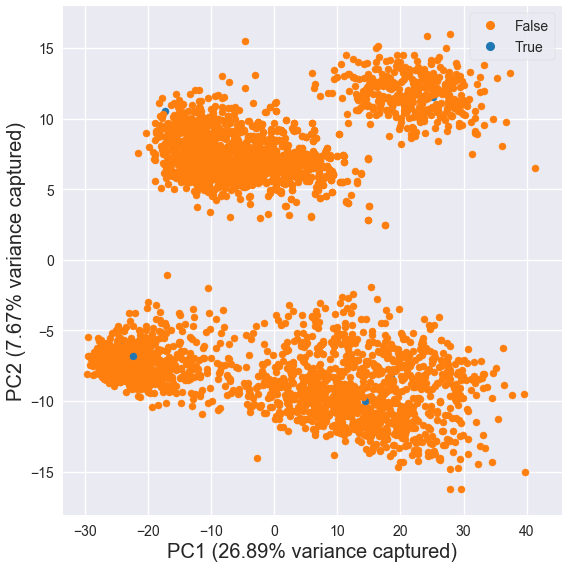

In [117]:
# Concat those two batches
print len(distil_ids_sub + distil_ids_sub2)
RNAseq.PCA_plot(mat_sub_sub2.T, 
                samples=np.in1d(distil_ids_sub + distil_ids_sub2, distil_ids+distil_ids2).astype(str), 
                standardize=2, log=False,  sep=':')

(3585, 978)
3585


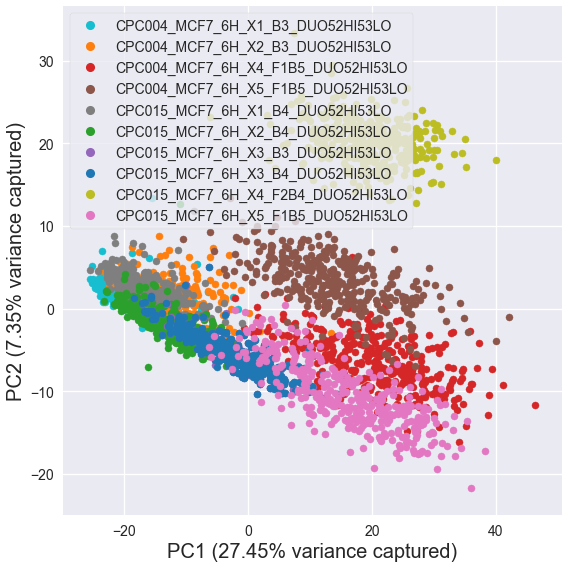

In [118]:
# Concat those two mean-centered batches
mat_sub2_centered = mat_sub2 - mat_sub2.mean(axis=0)
mat_sub_sub2_centered = np.vstack((mat_sub_centered, mat_sub2_centered))
print mat_sub_sub2.shape
print len(distil_ids_sub + distil_ids_sub2)
RNAseq.PCA_plot(mat_sub_sub2_centered.T, 
                samples=distil_ids_sub + distil_ids_sub2, 
                standardize=2, log=False,  sep=':')

(3585, 978)
3585


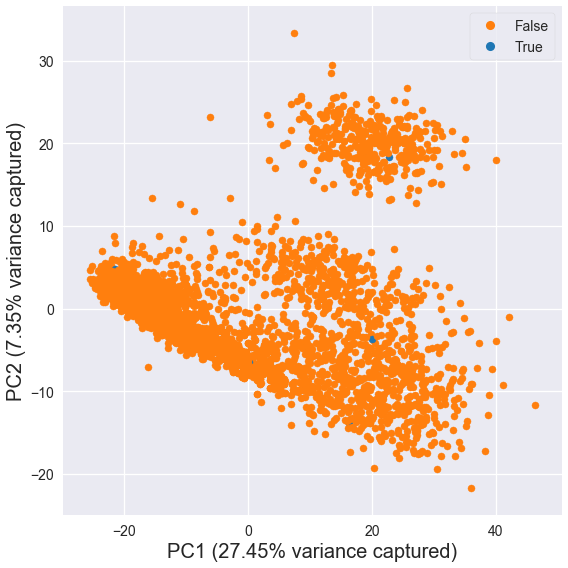

In [119]:
# Concat those two mean-centered batches
mat_sub2_centered = mat_sub2 - mat_sub2.mean(axis=0)
mat_sub_sub2_centered = np.vstack((mat_sub_centered, mat_sub2_centered))
print mat_sub_sub2.shape
print len(distil_ids_sub + distil_ids_sub2)
RNAseq.PCA_plot(mat_sub_sub2_centered.T, 
                samples=np.in1d(distil_ids_sub + distil_ids_sub2, distil_ids+distil_ids2).astype(str), 
                standardize=2, log=False,  sep=':')

In [120]:
# Do mean-centering on each plates
plates = map(lambda x:x.split(':')[0], distil_ids_sub + distil_ids_sub2)
print len(set(plates))
mat_sub_sub2_plate_mean_centered = np.zeros_like(mat_sub_sub2)
for plate in set(plates):
    plate_mask = np.in1d(plates, [plate])
    mat_sub_plate = mat_sub_sub2[plate_mask]
    print mat_sub_plate.shape
    mat_sub_sub2_plate_mean_centered[plate_mask, :] = mat_sub_plate - mat_sub_plate.mean(axis=0)


10
(361, 978)
(356, 978)
(362, 978)
(358, 978)
(361, 978)
(343, 978)
(363, 978)
(360, 978)
(364, 978)
(357, 978)


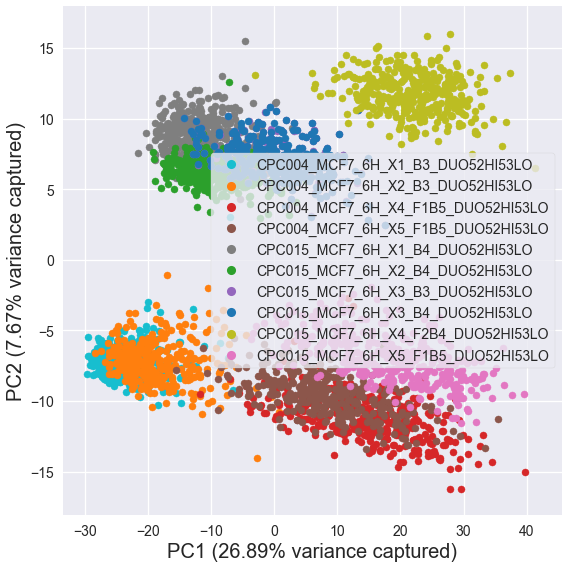

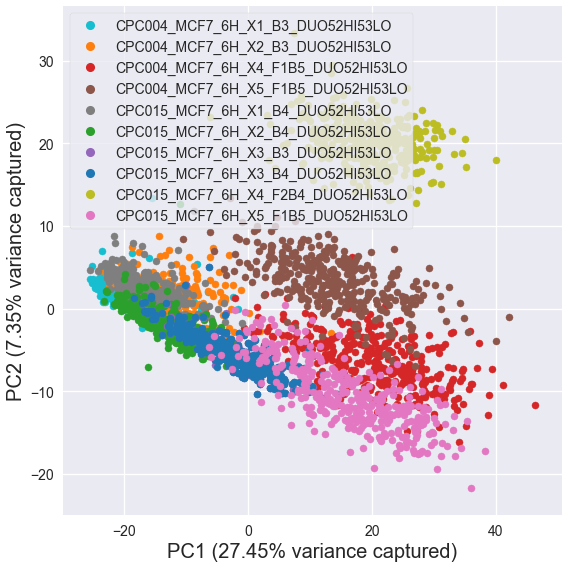

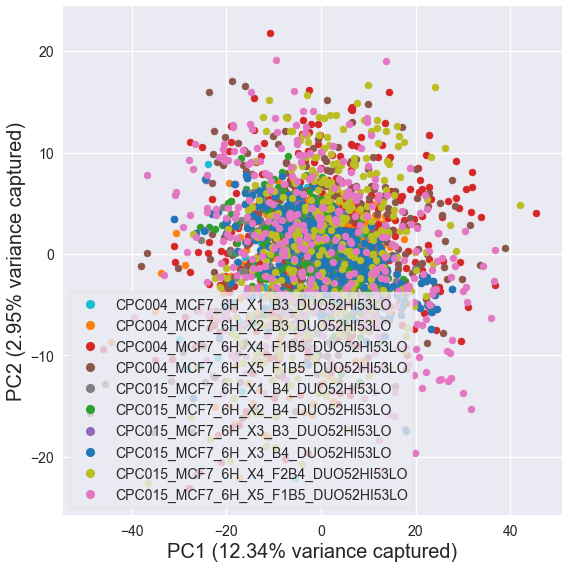

In [121]:
RNAseq.PCA_plot(mat_sub_sub2.T, 
                samples=distil_ids_sub + distil_ids_sub2, 
                standardize=2, log=False,  sep=':')

RNAseq.PCA_plot(mat_sub_sub2_centered.T, 
                samples=distil_ids_sub + distil_ids_sub2, 
                standardize=2, log=False,  sep=':')

RNAseq.PCA_plot(mat_sub_sub2_plate_mean_centered.T, 
                samples=distil_ids_sub + distil_ids_sub2, 
                standardize=2, log=False,  sep=':')

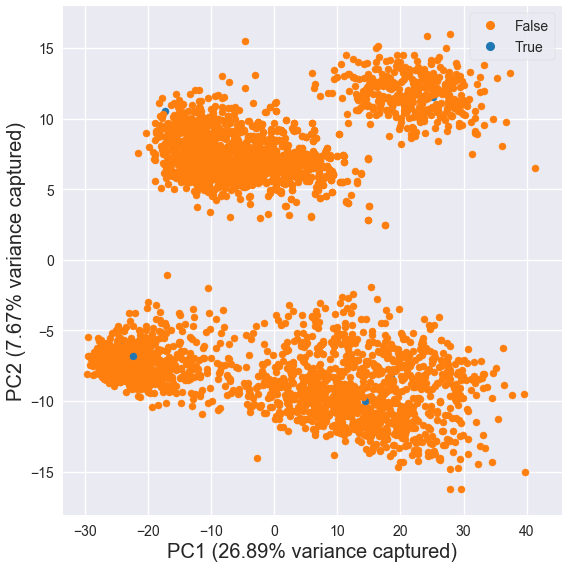

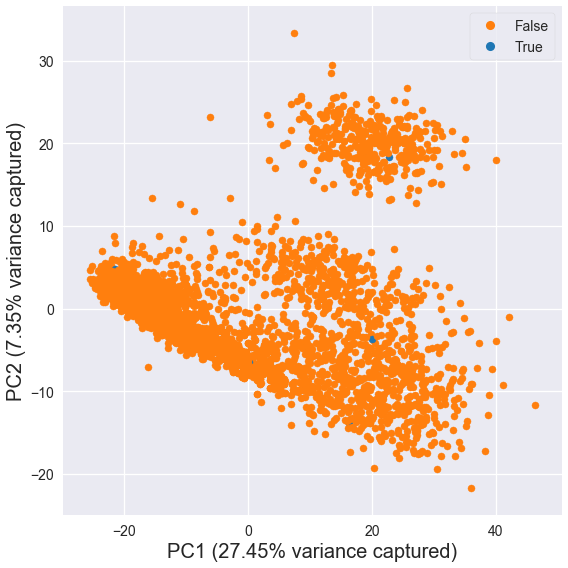

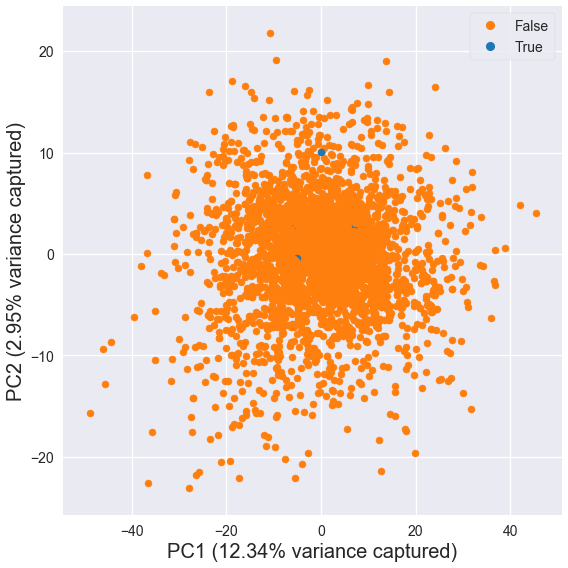

In [122]:
RNAseq.PCA_plot(mat_sub_sub2.T, 
                samples=np.in1d(distil_ids_sub + distil_ids_sub2, distil_ids+distil_ids2).astype(str),
                standardize=2, log=False,  sep=':')

RNAseq.PCA_plot(mat_sub_sub2_centered.T, 
                samples=np.in1d(distil_ids_sub + distil_ids_sub2, distil_ids+distil_ids2).astype(str),
                standardize=2, log=False,  sep=':')

RNAseq.PCA_plot(mat_sub_sub2_plate_mean_centered.T, 
                samples=np.in1d(distil_ids_sub + distil_ids_sub2, distil_ids+distil_ids2).astype(str),
                standardize=2, log=False,  sep=':')

## There are two levels of batch effects:
1. plates (biological replicates): CPC004_A375_6H_X1 vs CPC004_A375_6H_X2
2. batch: CPC004_A375_6H vs CPC015_A375_6H

---